In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input, Lambda,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import cv2



2023-03-28 08:32:36.166421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 08:32:37.115264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-28 08:32:37.115449: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-28 08:32:41.572142: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-28

In [2]:
# Define image dimensions and number of classes
img_width, img_height = 224, 224

In [3]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

def rgb_to_hsv(x):
    hsv = tf.image.rgb_to_hsv(x)
    return hsv

def rgb_to_ycbcr(x):
    ycbcr = tf.image.rgb_to_yuv(x)
    return ycbcr

input_shape = (224, 224, 3)

# Define inputs
rgb_input = Input(shape=input_shape, name='rgb_input')

# Preprocess inputs
hsv_input = tf.keras.layers.Lambda(rgb_to_hsv, name='hsv_input')(rgb_input)
ycbcr_input = tf.keras.layers.Lambda(rgb_to_ycbcr, name='ycbcr_input')(rgb_input)


In [4]:
# Create MobileNetV2 model
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False
# Concatenate all outputs of the base model
rgb_output, hsv_output, ycbcr_output = base_model(rgb_input), base_model(hsv_input), base_model(ycbcr_input)
concatenated_output = Concatenate()([rgb_output, hsv_output, ycbcr_output])

# Add a global average pooling layer
x = GlobalAveragePooling2D()(concatenated_output)

# Add classification layers
# x = Dense(512, activation='relu')(x)
# x=  Dropout(.2)(x)
# x = Dense(256, activation='relu')(x)
# x=  Dropout(.2)(x)
# x = Dense(128, activation='relu')(x)
# x=  Dropout(.2)(x)
x = Dense(256, activation='relu')(x)
x=  Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

# Create final model
model = Model(inputs=[rgb_input], outputs=[output])
model.summary()


2023-03-28 08:32:55.845115: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mrizwan/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-28 08:32:55.845362: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-28 08:32:55.845518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-PV5U7I0): /proc/driver/nvidia/version does not exist
2023-03-28 08:32:55.846559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate comp

9406464/9406464 [==============================] - 8s 1us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rgb_input (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 hsv_input (Lambda)             (None, 224, 224, 3)  0           ['rgb_input[0][0]']              
                                                                                                  
 ycbcr_input (Lambda)           (None, 224, 224, 3)  0           ['rgb_input[0][0]']              
                                                                                                  
 mobilenetv2_1.00_224 (Function

In [6]:
# base_model.summary()

In [7]:
# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])



In [1]:
# Define data generators for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/apple_banana/data/train',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/apple_banana/data/train',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)



In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
21/21 [==============================] - 187s 8s/step - loss: 0.2157 - accuracy: 0.9306 - val_loss: 7.8440e-06 - val_accuracy: 1.0000
Epoch 2/10
21/21 [==============================] - 7s 330ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.2336e-06 - val_accuracy: 1.0000
Epoch 3/10
21/21 [==============================] - 6s 285ms/step - loss: 2.0015e-05 - accuracy: 1.0000 - val_loss: 1.5499e-06 - val_accuracy: 1.0000
Epoch 4/10
21/21 [==============================] - 6s 286ms/step - loss: 1.3618e-05 - accuracy: 1.0000 - val_loss: 1.4919e-06 - val_accuracy: 1.0000
Epoch 5/10
21/21 [==============================] - 8s 376ms/step - loss: 3.1581e-05 - accuracy: 1.0000 - val_loss: 1.4352e-06 - val_accuracy: 1.0000
Epoch 6/10
21/21 [==============================] - 6s 287ms/step - loss: 2.9724e-05 - accuracy: 1.0000 - val_loss: 1.3683e-06 - val_accuracy: 1.0000
Epoch 7/10
21/21 [==============================] - 7s 305ms/step - loss: 1.2796e-04 - accuracy: 1.0000 - val

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/apple_banana/apple_banana.h5')


In [ ]:
# Evaluate the model on test data
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/apple_banana/data/test',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    shuffle=False

)

# scores = model.evaluate(test_generator)
# print("Test Accuracy: %.2f%%" % (scores[1]*100))

Found 217 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/apple_banana/apple_banana.h5')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
batch_size=test_generator.batch_size
y_pred = loaded_model.predict(test_generator, steps=test_generator.n//batch_size+1)
y_pred = np.round(y_pred)

# Load the true class labels
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(cm)


# Generate the classification report and confusion matrix
target_names = ['apple', 'banana']
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)


7/7 [==============================] - 2s 218ms/step
[[112   0]
 [  0 105]]
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00       112
      banana       1.00      1.00      1.00       105

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217



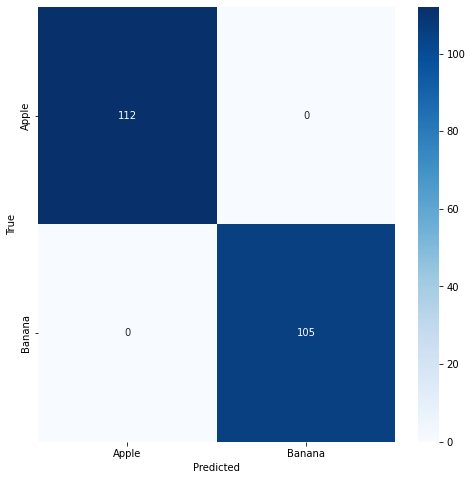

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0.5, 1.5], ["Apple", "Banana"])
plt.yticks([0.5, 1.5], ["Apple", "Banana"])

plt.show()

1/1 [==============================] - 2s 2s/step


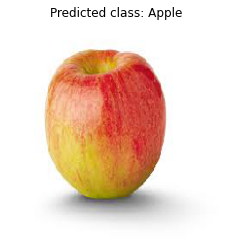

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/apple_banana/apple_banana.h5')

# Load and preprocess the image
img_path = '/content/Apple.jpeg'
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make predictions on the image
pred = model.predict(img_array)[0]
class_names = ['Apple', 'Banana']
class_idx = int(pred > 0.5)
class_name = class_names[class_idx]

# Display the image and prediction
plt.imshow(img)
plt.axis('off')
plt.title('Predicted class: {}'.format(class_name))
plt.show()

1/1 [==============================] - 0s 42ms/step


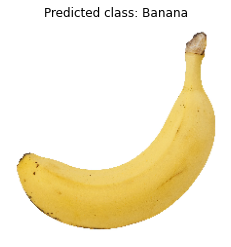

In [ ]:
# Load and preprocess the image
img_path = '/content/Banana.jpg'
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make predictions on the image
pred = model.predict(img_array)[0]
class_names = ['Apple', 'Banana']
class_idx = int(pred > 0.5)
class_name = class_names[class_idx]

# Display the image and prediction
plt.imshow(img)
plt.axis('off')
plt.title('Predicted class: {}'.format(class_name))
plt.show()